In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import datetime
import yfinance as yf



In [2]:
asssets = ['NVDA',  'MSFT', 'AMZN'] #'AAPL',

data = pd.DataFrame()


In [3]:
start_date = datetime.datetime(2019, 1, 1)
end_date = datetime.datetime.now()
for t in asssets:
    data[t] = yf.download(t, start=start_date, end=end_date)['Adj Close']


data.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,NVDA,AAPL,MSFT,AMZN
Date,,,,
2019-01-02,33.790485,37.845036,95.846031,76.956497
2019-01-03,31.748959,34.075401,92.320038,75.014000
2019-01-04,33.783031,35.530052,96.613777,78.769501
2019-01-07,35.571533,35.450966,96.736977,81.475502
2019-01-08,34.685970,36.126774,97.438393,82.829002


In [4]:
log_returns = np.log(1+data.pct_change())

port_returns = []
port_volts = []

for i in range(1000):
    num_assets = len(asssets)
    weigths = np.random.random(num_assets)
    weigths /= np.sum(weigths)
    port_returns.append(np.sum(weigths*log_returns.mean())*252)
    port_volts.append(np.sqrt(np.dot(weigths.T, np.dot(log_returns.cov()*252, weigths))))

port_returns = np.array(port_returns)
port_volts = np.array(port_volts)

In [5]:
def portfolio_stats(weigths, log_returns):
    port_returns = np.sum(weigths*log_returns.mean())*252
    port_volts   = np.sqrt(np.dot(weigths.T, np.dot(log_returns.cov()*252, weigths)))

    sharpe =  port_returns/port_volts
    return {'Return': port_returns, 'Volatility': port_volts, 'Sharpe': sharpe}



In [6]:
sharpe = port_returns/port_volts
max_sr_returns = port_returns[sharpe.argmax()]
max_sr_volatility = port_volts[sharpe.argmax()]

In [7]:
def minimize_sharpe(weigths, log_returns):
    return -portfolio_stats(weigths=weigths, log_returns=log_returns)['Sharpe']

initializer = num_assets*[1./num_assets,]
bounds = tuple((0,1) for x in range(num_assets))

print(initializer, bounds)

[0.25, 0.25, 0.25, 0.25] ((0, 1), (0, 1), (0, 1), (0, 1))


minimize
metodo par aminimizar funcion 
- 'Nelder-Mead' `(see here) <optimize.minimize-neldermead>`
- 'Powell'      `(see here) <optimize.minimize-powell>`
- 'CG'          `(see here) <optimize.minimize-cg>`
- 'BFGS'        `(see here) <optimize.minimize-bfgs>`
- 'Newton-CG'   `(see here) <optimize.minimize-newtoncg>`
- 'L-BFGS-B'    `(see here) <optimize.minimize-lbfgsb>`
- 'TNC'         `(see here) <optimize.minimize-tnc>`
- 'COBYLA'      `(see here) <optimize.minimize-cobyla>`
- 'SLSQP'       `(see here) <optimize.minimize-slsqp>`
- 'trust-constr'`(see here) <optimize.minimize-trustconstr>`
- 'dogleg'      `(see here) <optimize.minimize-dogleg>`
- 'trust-ncg'   `(see here) <optimize.minimize-trustncg>`
- 'trust-exact' `(see here) <optimize.minimize-trustexact>`
- 'trust-krylov' `(see here) <optimize.minimize-trustkrylov>`

In [8]:
optimar_sharpe = optimize.minimize(minimize_sharpe, initializer, method='SLSQP', args=(log_returns,), bounds=bounds)
optimar_sharpe_weights = optimar_sharpe['x'].round(3)
optimar_sharpe

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.210651351381234
       x: [ 7.179e-01  3.698e-01  0.000e+00  0.000e+00]
     nit: 7
     jac: [-5.975e-06  1.159e-05  1.357e-03  2.614e-01]
    nfev: 35
    njev: 7

In [9]:
optimal_stats  = portfolio_stats(optimar_sharpe_weights, log_returns=log_returns)
optimal_return = np.round(optimal_stats['Return']*100,3)
optimal_volatility = np.round(optimal_stats['Volatility']*100,3)
optimal_sharpe = np.round(optimal_stats['Sharpe'],3)

In [10]:
print(f'Los pesos optimos en la cartera son: {list(zip(asssets, list(optimar_sharpe_weights*100)))}')
# print(f'Retorno optimo de la cartera: {np.round(optimal_stats['Return']*100,3)}')
print(f'Retorno optimo de la cartera: {optimal_return}')
print(f'Volatilidad optimo de la cartera: {optimal_volatility}')
print(f'Sharpe optimo de la cartera: {optimal_sharpe}')

Los pesos optimos en la cartera son: [('NVDA', 71.8), ('AAPL', 37.0), ('MSFT', 0.0), ('AMZN', 0.0)]
Retorno optimo de la cartera: 55.274
Volatilidad optimo de la cartera: 45.657
Sharpe optimo de la cartera: 1.211


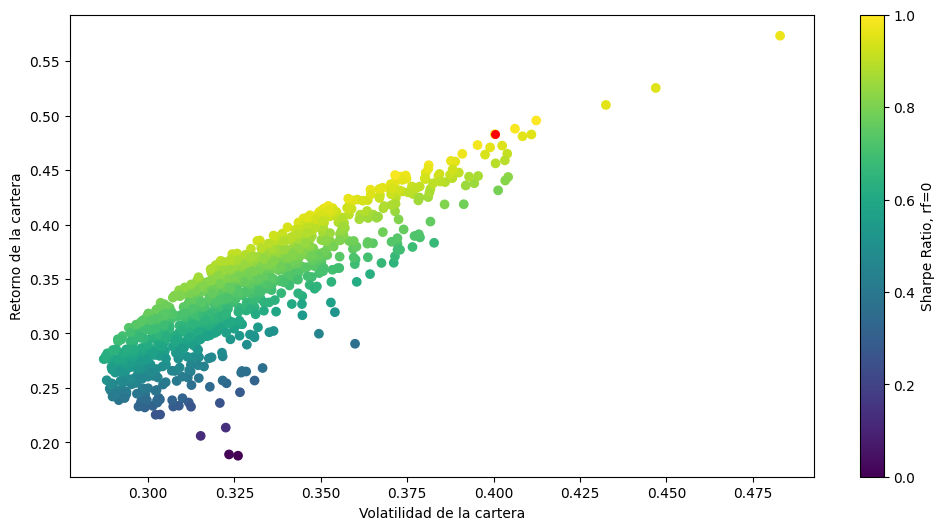

In [11]:
plt.figure(figsize=(12,6))
plt.scatter(port_volts, port_returns, c= (port_returns/port_volts))
plt.scatter(max_sr_volatility,max_sr_returns, c= 'red', s=30)
plt.colorbar(label = 'Sharpe Ratio, rf=0')
plt.xlabel('Volatilidad de la cartera')
plt.ylabel('Retorno de la cartera')
plt.show()